In [1]:
!pip install transformers torch scikit-learn pandas

In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from transformers import logging

logging.set_verbosity_error()

model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

csv_path = 'reviews.csv'
df = pd.read_csv(csv_path)

# Define function for sentiment analysis
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    score = torch.argmax(probs).item() + 1  # 1 to 5 scale
    confidence = torch.max(probs).item()

    if score >= 4:
        sentiment = "Positive"
    elif score == 3:
        sentiment = "Neutral"
    else:
        sentiment = "Negative"
    
    return sentiment, score, round(confidence, 2)

df[['Sentiment', 'Predicted Star Rating', 'Confidence']] = df['content'].apply(
    lambda x: pd.Series(analyze_sentiment(str(x)))
)

print(df[['content', 'Sentiment', 'Predicted Star Rating', 'Confidence']])

df.to_csv('reviews_with_sentiment.csv', index=False)

                                                content Sentiment  \
0                         I cannot open the app anymore  Negative   
1     I have been begging for a refund from this app...  Negative   
2     Very costly for the premium version (approx In...  Negative   
3     Used to keep me organized, but all the 2020 UP...  Negative   
4                                   Dan Birthday Oct 28  Positive   
...                                                 ...       ...   
1995  They double billed me for my premium subscript...  Negative   
1996                   This is the beat app of all !!!!  Positive   
1997  I downloaded this app after hearing good thing...  Negative   
1998  It just vibrate I never get an alert. It only ...  Negative   
1999                                 Problem with login  Negative   

      Predicted Star Rating  Confidence  
0                         1        0.65  
1                         1        0.82  
2                         2        0.51  
3  

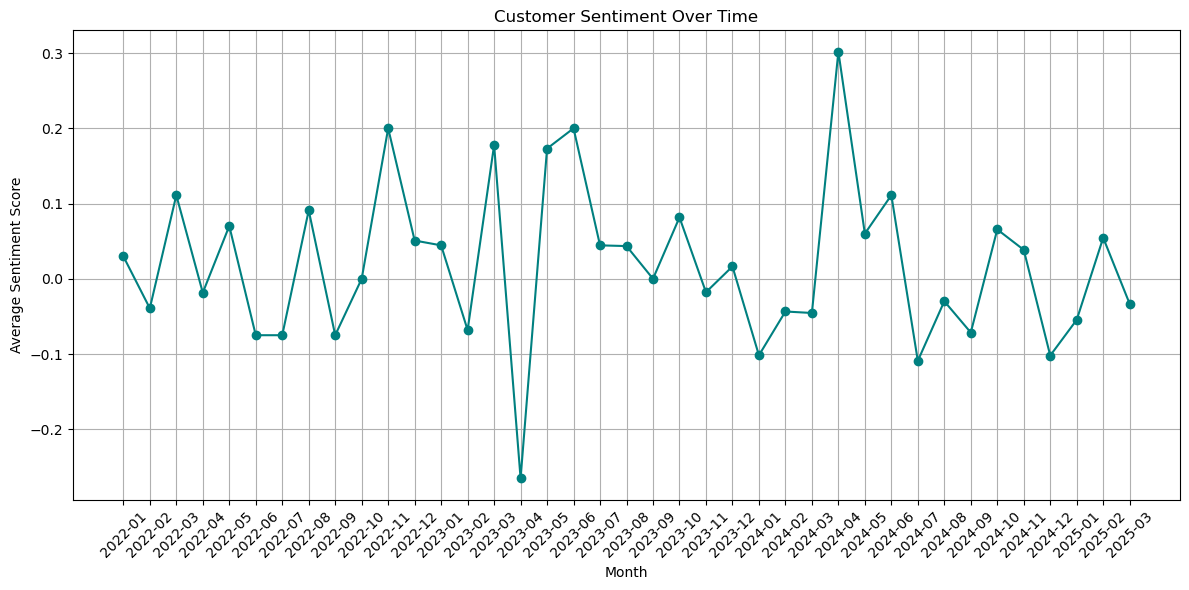

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("final_reviews.csv")

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['Month'] = df['date'].dt.to_period('M').astype(str)

sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['Sentiment Score'] = df['Sentiment'].map(sentiment_map)

timeline = df.groupby('Month')['Sentiment Score'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(timeline['Month'], timeline['Sentiment Score'], marker='o', color='teal')
plt.title('Customer Sentiment Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Detection columns added!


C:\Users\Sonith\AppData\Local\Temp\ipykernel_31012\3356848511.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=suspicious_reviews, x='Predicted Star Rating', palette='flare')


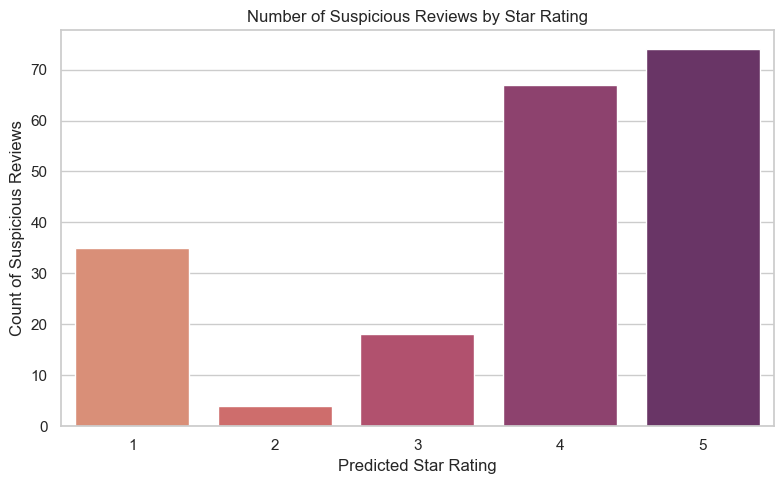

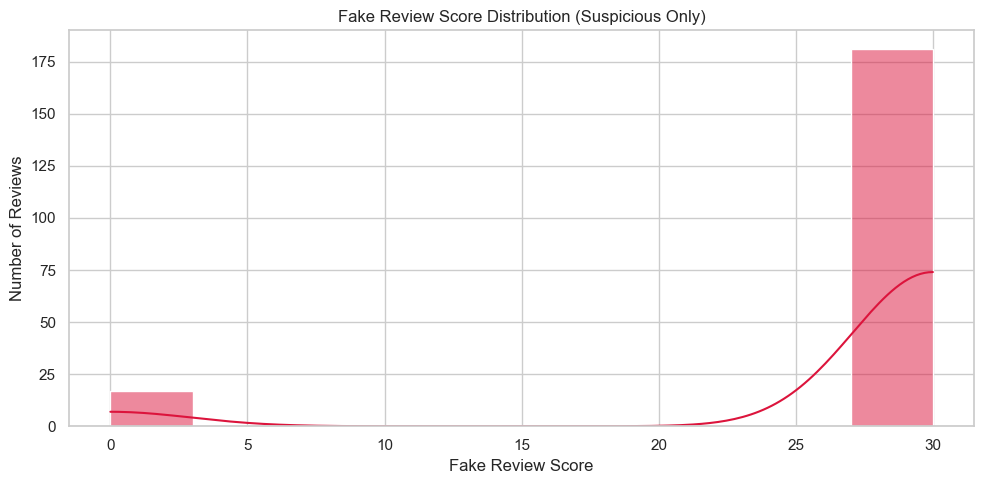

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("reviews_with_sentiment.csv")

def is_potentially_fake(review, sentiment, rating):
    if pd.isnull(review):
        return False
    review = str(review)
    if len(review) < 10:
        return True
    if sentiment == "Positive" and rating <= 2:
        return True
    if sentiment == "Negative" and rating >= 4:
        return True
    if review.count("!") > 3:
        return True
    return False

def fake_review_score(review, sentiment, rating):
    score = 0
    if pd.isnull(review):
        return 0
    review = str(review).lower()
    if len(review) < 15:
        score += 30
    if review.count("great") > 2:
        score += 20
    if sentiment == "Positive" and rating <= 2:
        score += 30
    if "buy now" in review:
        score += 20
    return min(score, 100)

df['Rule_Flag'] = df.apply(lambda row: is_potentially_fake(row['content'], row['Sentiment'], row['Predicted Star Rating']), axis=1)
df['Fake_Review_Score'] = df.apply(lambda row: fake_review_score(row['content'], row['Sentiment'], row['Predicted Star Rating']), axis=1)
df['Suspicious'] = (df['Rule_Flag']) | (df['Fake_Review_Score'] > 50)

df.to_csv("reviews_with_fake_detection.csv", index=False)

print("✅ Detection columns added!")

suspicious_reviews = df[df['Suspicious']].sort_values(by='Fake_Review_Score', ascending=False)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(data=suspicious_reviews, x='Predicted Star Rating', palette='flare')
plt.title('Number of Suspicious Reviews by Star Rating')
plt.xlabel('Predicted Star Rating')
plt.ylabel('Count of Suspicious Reviews')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(suspicious_reviews['Fake_Review_Score'], bins=10, kde=True, color='crimson')
plt.title('Fake Review Score Distribution (Suspicious Only)')
plt.xlabel('Fake Review Score')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()